## 🧠 Projekt: ,,Prognozowanie inflacji w Polsce z wykorzystaniem sieci LSTM"
*Autorzy: Franciszek Samiec (89754), Radosław Rybakowski (109174), Kamila Fraid (108949)*


### Wstęp
##### ➡️ Celem projektu jest stworzenie modelu prognozującego inflację CPI w Polsce na podstawie danych ekonomicznych i rynkowych.
Co więcej, celem naszego projektu jest stworzenie skutecznego modelu prognozującego inflację CPI w Polsce, który mógłby konkurować z predykcjami innych instytucji i ośrodków analitycznych. W dobie niepewności gospodarczej i zmienności rynków, trafne prognozy inflacyjne mają ogromne znaczenie dla polityki pieniężnej i decyzji biznesowych. Chcemy pokazać, że przy użyciu nowoczesnych metod uczenia maszynowego, takich jak LSTM, możliwe jest osiągnięcie wysokiej dokładności predykcji. Naszym „rywalem” są m.in. prognozy publikowane przez banki centralne, instytuty finansowe czy agencje rządowe. Nasz model ma być nowoczesną alternatywą opartą na danych i technologii.

##### Dane pochodzą z Eurostatu, GUS oraz rynków finansowych (kursy USD/PLN, EUR/PLN, ceny ropy Brent).
##### Dane są przetwarzane, czyszczone i standaryzowane, a następnie wykorzystywane do trenowania modelu LSTM.



*LSTM (Long Short-Term Memory) to rodzaj rekurencyjnej sieci neuronowej (RNN), która potrafi uczyć się długoterminowych zależności w danych sekwencyjnych. Dzięki specjalnym mechanizmom bramek (zapominania, wejściowej i wyjściowej), LSTM skutecznie radzi sobie z problemem zanikającego gradientu, typowym dla tradycyjnych RNN. Jest szeroko stosowany m.in. w przetwarzaniu języka naturalnego, rozpoznawaniu mowy i prognozowaniu szeregów czasowych.*

#### Spis Treści
* Opis zbiorów danych
* Pobieranie, przygotowanie i analiza danych
* Eksploracja i transformacja danych - łączenie danych
* Budowa i trenowanie modelu LSTM
* Selekcja cech (feature selection)
* Analiza wyników i wizualizacja
* Bibliografia

## ➡️ Opis zbiorów danych

Dane są zbierane z różnych źródeł (Eurostat, GUS, Stooq, pliki CSV).

Wszystkie zestawy danych dotyczą okresu od około 2000 do 2025 roku i odnoszą się do Polski lub istotnych zmiennych makroekonomicznych i rynkowych powiązanych z inflacją.

Wybrano zestaw 15 zmiennych, które zostały wybrane ekspercko jako ten o największym znaczeniu dla procesów inflacyjnych w świetle teorii ekonomicznych. Należy wspomnieć, że ośrodki profesjonalnie zajmujące się modelowaniem inflacji wykorzystują znacznie większą ilość zmiennych w swoich modelach.

** 1. Eurostat (dane makroekonomiczne kwartalne):
Zawiera kwartalne dane dotyczące PKB, konsumpcji, inwestycji, eksportu i importu Polski od 2000 roku. Dane są przetworzone do formatu z datami kwartalnymi i przygotowane do dalszej analizy inflacji.

** 2. GUS i NBP (dane miesięczne i kwartalne):
GUS oferuje kwartalne o PKB a także miesięczne dane o bezrobociu, wynagrodzeniach i wskaźnikach cen. NBP zaś, raportuje dane o stopie procentowej, podaży pieniądza M3 oraz oczekiwaniach inflacyjnych przedsiębiorstw.

** 3. Stooq (dane rynkowe walutowe):
Zawiera dzienne kursy USD/PLN i EUR/PLN, które zostały uśrednione do danych miesięcznych od 2000 roku. Przygotowane są do połączenia z innymi danymi makroekonomicznymi w celu modelowania.

** 4. Dane o cenach ropy Brent:
Przechowuje miesięczne średnie ceny ropy Brent od 2000 roku, pochodzące z danych dziennych. Dane zostały przekształcone do formatu miesięcznego i oczyszczone do dalszej analizy.

Dane kwartalne w były dezaagregowane do miesięcy, przydzielając odpowiadające danemu kwartałowi wartości poszczególnym miesiącom.

W przypadku wszystkich rodzajów danych, starano się aby miały one charakter zmiennych stacjonarnych. W większości przypadku sprowadzało się to obliczania dynamik tych zmiennych. W niektórych przypadkach nie było to konieczne - np kursy walutowe czy oczekiwania inflacyjne.

Przetworzone dane gotowe są do dalszej analizy i modelowania, np. budowy modeli LSTM do prognozowania inflacji. 

In [3]:
import eurostat
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.backend import clear_session
from tqdm import tqdm
import seaborn as sns
import matplotlib.dates as mdates

## EUROSTAT dane

In [ ]:
toc_df = eurostat.get_toc_df()

In [ ]:
toc_df.to_excel("datasets_eurostat.xlsx", index=False)

In [ ]:
eurostat.get_pars("MIPS_SA")

['freq', 'indic_ip', 'release', 'indic', 'geo']

In [ ]:
dic = eurostat.get_dic("GOV_10DD_EDPT1", "sector")


In [ ]:
gdp_data =  eurostat.get_data_df("namq_10_gdp",filter_pars = {"geo": ["PL"]})

In [ ]:
selected_vars = ["B1GQ", "P3", 'P5G', 'P6', 'P7']

In [ ]:
dic_item = eurostat.get_dic("namq_10_gdp", "na_item")
dic_unit = eurostat.get_dic("namq_10_gdp", "unit")

In [ ]:
dict_item_dataset = {k : v for k, v in dict(dic_item).items() if k in gdp_data["na_item"].drop_duplicates().tolist()}
dict_unit_dataset = {k : v for k, v in dict(dic_unit).items() if k in gdp_data["unit"].drop_duplicates().tolist()}

In [ ]:
selected_vars_dict = {k : v for k, v in dict(dic_item).items() if k in selected_vars}
selected_vars_dict

{'B1GQ': 'Gross domestic product at market prices',
 'P3': 'Final consumption expenditure',
 'P5G': 'Gross capital formation',
 'P6': 'Exports of goods and services',
 'P7': 'Imports of goods and services'}

In [ ]:
quarter_start_month = {
    'Q1': '01',
    'Q2': '04',
    'Q3': '07',
    'Q4': '10'
}

In [ ]:
eurostat_macro_df= gdp_data[gdp_data["na_item"].isin(selected_vars)].melt(id_vars = ["freq", "unit", "s_adj", "na_item", "geo\TIME_PERIOD"]).dropna(subset = ["value"])
eurostat_macro_df[['Year', 'Quarter']] = eurostat_macro_df["variable"].str.split('-', expand=True)
eurostat_macro_df['date'] = eurostat_macro_df['Year'] + '-' + eurostat_macro_df['Quarter'].map(quarter_start_month) + '-01'
eurostat_macro_df['date'] = pd.to_datetime(eurostat_macro_df['date'])
eurostat_macro_df = eurostat_macro_df[(eurostat_macro_df["date"].dt.year > 1999) & (eurostat_macro_df["s_adj"] == "NSA") & (eurostat_macro_df["unit"] == "CLV_PCH_SM")]
eurostat_macro_df.drop(columns = ["freq", "unit", "s_adj", "geo\TIME_PERIOD", "Quarter", "variable", "Year"], inplace = True)
eurostat_macro_df["na_item"] = eurostat_macro_df["na_item"].map(dict_item_dataset)
eurostat_macro_df = pd.pivot(eurostat_macro_df, index = ["date"], columns = "na_item", values = "value").reset_index()


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
C:\Users\rados\AppData\Local\Temp\ipykernel_22984\864983065.py:1: SyntaxWarning: invalid escape sequence '\T'
  eurostat_macro_df= gdp_data[gdp_data["na_item"].isin(selected_vars)].melt(id_vars = ["freq", "unit", "s_adj", "na_item", "geo\TIME_PERIOD"]).dropna(subset = ["value"])
C:\Users\rados\AppData\Local\Temp\ipykernel_22984\864983065.py:6: SyntaxWarning: invalid escape sequence '\T'
  eurostat_macro_df.drop(columns = ["freq", "unit", "s_adj", "geo\TIME_PERIOD", "Quarter", "variable", "Year"], inplace = True)


In [ ]:
eurostat_macro_df

na_item       date Exports of goods and services  \
0       2000-01-01                          19.9   
1       2000-04-01                          24.3   
2       2000-07-01                          13.9   
3       2000-10-01                          36.5   
4       2001-01-01                           5.1   
..             ...                           ...   
96      2024-01-01                           3.1   
97      2024-04-01                           6.0   
98      2024-07-01                          -1.5   
99      2024-10-01                           0.5   
100     2025-01-01                           NaN   

na_item Final consumption expenditure Gross capital formation  \
0                                 4.7                     6.0   
1                                 2.4                     2.0   
2                                 4.5                    -3.9   
3                                 4.8                     2.3   
4                                 1.7                    -7.3   
..                                ...                     ...   
96                                5.1                   -20.9   
97                                5.7                     0.4   
98                                1.7                    21.8   
99                                4.8                     8.5   
100                               NaN                     NaN   

na_item Gross domestic product at market prices Imports of goods and services  
0                                           6.2                          13.0  
1                                           4.8                          11.5  
2                                           3.0                          10.4  
3                                           4.7                          26.8  
4                                           3.3                          -4.1  
..                                          ...                           ...  
96                                          1.5                           2.7  
97                                          4.4                           7.1  
98                                          1.6                           4.4  
99                                          4.1                           2.9  
100                                         3.7                           NaN  

[101 rows x 6 columns]

## GUS dane

In [ ]:
gus_raw.keys()


dict_keys(['Dane_miesięczne', 'Dane_kwartalne'])

In [ ]:

gus_monthly = pd.read_excel("0_rawdata\gus_data.xlsx", sheet_name="Dane_miesięczne")
gus_quarterly =  pd.read_excel("0_rawdata\gus_data.xlsx", sheet_name='Dane_kwartalne', index_col=[0,1]).reset_index()

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\rados\AppData\Local\Temp\ipykernel_22984\656996444.py:1: SyntaxWarning: invalid escape sequence '\g'
  gus_monthly = pd.read_excel("0_rawdata\gus_data.xlsx", sheet_name="Dane_miesięczne")
C:\Users\rados\AppData\Local\Temp\ipykernel_22984\656996444.py:2: SyntaxWarning: invalid escape sequence '\g'
  gus_quarterly =  pd.read_excel("0_rawdata\gus_data.xlsx", sheet_name='Dane_kwartalne', index_col=[0,1]).reset_index()


In [ ]:
quarter_2 = {
        '1' : '01',
        '2': '04',
        '3' : '07',
        '4' : '10'
}

In [ ]:
gus_q_df = gus_quarterly.copy()
gus_q_df["Kwartał"] = gus_q_df["Kwartał"].str.replace(" kw.", "")
gus_q_df['date'] = gus_q_df['Rok'].astype(str) + '-' + gus_q_df['Kwartał'].astype(str).map(quarter_2) + '-01'
gus_q_df['date'] = pd.to_datetime(gus_q_df['date'])
gus_q_df.drop(columns = ["Kwartał", "Rok"], inplace = True)

In [ ]:
gus_q_df

Podaż pieniądza M3 (stan w końcu okresu)  \
0                                      114,0   
1                                      120,3   
2                                      114,7   
3                                      111,9   
4                                      114,7   
..                                       ...   
96                                     106,6   
97                                     108,4   
98                                     106,5   
99                                     109,3   
100                                    110,3   

    Produkt krajowy brutto (ceny stale)c  \
0                                  106,5   
1                                  105,7   
2                                  103,4   
3                                  102,6   
4                                  102,4   
..                                   ...   
96                                101,9a   
97                                102,2a   
98                                102,3a   
99                                102,5a   
100                                  NaN   

     Oczekiwania inflacyjne przedsiębiorstw       date  
0                                       NaN 2000-01-01  
1                                       NaN 2000-04-01  
2                                       NaN 2000-07-01  
3                                       NaN 2000-10-01  
4                                       NaN 2001-01-01  
..                                      ...        ...  
96                                15.745192 2024-01-01  
97                                43.466828 2024-04-01  
98                                34.292663 2024-07-01  
99                                36.773795 2024-10-01  
100                               28.368794 2025-01-01  

[101 rows x 4 columns]

In [ ]:
gus_m_df = gus_monthly.copy()
gus_m_df['date'] = gus_m_df['Rok'].astype(str) + '-' + gus_m_df.astype(str)['Miesiąc']
gus_m_df['date'] = pd.to_datetime(gus_m_df['date'])
gus_m_df["Bieżący wskaźnik ufności konsumenckiej (BWUK)"].replace({".": pd.NA}, inplace = True)
gus_m_df.drop(columns = ["Rok", "Miesiąc"], inplace = True)
gus_m_df = gus_m_df.fillna(method="ffill")
gus_m_df

C:\Users\rados\AppData\Local\Temp\ipykernel_22984\7894805.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gus_m_df = gus_m_df.fillna(method="ffill")


Stopa bezrobocia rejestrowanego  \
0                               13.7   
1                               14.0   
2                               14.0   
3                               13.8   
4                               13.6   
..                               ...   
307                              5.3   
308                              5.3   
309                              5.3   
310                              5.3   
311                              5.3   

     Przeciętne miesięczne nominalne wynagrodzenie brutto w sektorze przedsiębiorstwa  \
0                                                  NaN                                  
1                                                  NaN                                  
2                                                  NaN                                  
3                                                  NaN                                  
4                                                  NaN                                  
..                                                 ...                                  
307                                              107.7                                  
308                                              107.7                                  
309                                              107.7                                  
310                                              107.7                                  
311                                              107.7                                  

     Bieżący wskaźnik ufności konsumenckiej (BWUK)  \
0                                            -32.9   
1                                            -32.9   
2                                            -32.9   
3                                            -33.5   
4                                            -33.5   
..                                             ...   
307                                          -16.5   
308                                          -16.5   
309                                          -16.5   
310                                          -16.5   
311                                          -16.5   

    Wskaźniki cen towarów i usług konsumpcyjnych       date  
0                                          110,1 2000-01-01  
1                                          110,4 2000-02-01  
2                                          110,3 2000-03-01  
3                                          109,8 2000-04-01  
4                                          110,0 2000-05-01  
..                                           ...        ...  
307                                        104,9 2025-08-01  
308                                        104,9 2025-09-01  
309                                        104,9 2025-10-01  
310                                        104,9 2025-11-01  
311                                        104,9 2025-12-01  

[312 rows x 5 columns]

## Stooq dane

In [ ]:
usdpln_d = pd.read_csv("0_rawdata/usdpln_d.csv")
eurpln_d = pd.read_csv("0_rawdata/eurpln_d.csv")

In [ ]:
eurpln_df = eurpln_d.copy()
usdpln_df = usdpln_d.copy()
eurpln_df["date"] = pd.to_datetime(eurpln_df["Data"])
eurpln_df.drop(columns = ["Data"], inplace = True)
usdpln_df["date"] = pd.to_datetime(usdpln_df["Data"])
usdpln_df.drop(columns = ["Data"], inplace = True)
usdpln_df["date"] = usdpln_df["date"].dt.to_period('M').dt.to_timestamp()
eurpln_df["date"] = eurpln_df["date"].dt.to_period('M').dt.to_timestamp()
stooq_df = usdpln_df.groupby("date")["Zamkniecie"].mean().to_frame("stock_USDPLN")
stooq_df["stock_EURPLN"] = eurpln_df.groupby("date")["Zamkniecie"].mean()
stooq_df.reset_index(inplace = True)
stooq_df = stooq_df[stooq_df["date"].dt.year > 1999]

In [ ]:
stooq_df

date  stock_USDPLN  stock_EURPLN
192 2000-01-01      4.100857      4.153024
193 2000-02-01      4.143333      4.077543
194 2000-03-01      4.086935      3.942770
195 2000-04-01      4.236053      4.007063
196 2000-05-01      4.481452      4.069086
..         ...           ...           ...
492 2025-01-01      4.097845      4.244146
493 2025-02-01      4.005179      4.173267
494 2025-03-01      3.866003      4.181095
495 2025-04-01      3.801656      4.264490
496 2025-05-01      3.788023      4.257463

[305 rows x 3 columns]

## Oil dane

In [ ]:
oil_raw = pd.read_csv("0_rawdata/Brent Oil Futures Historical Data (1).csv")

In [ ]:
oil_df = oil_raw.copy()
oil_df["date"] = pd.to_datetime(oil_df["Date"]) 
oil_df = oil_df.groupby("date")["Price"].mean().to_frame("stock_brent_oil").reset_index()
oil_df = oil_df[oil_df["date"].dt.year > 1999]
oil_df

date  stock_brent_oil
138 2000-01-01            25.97
139 2000-02-01            28.09
140 2000-03-01            24.77
141 2000-04-01            23.89
142 2000-05-01            28.31
..         ...              ...
438 2025-01-01            76.76
439 2025-02-01            73.18
440 2025-03-01            74.74
441 2025-04-01            63.12
442 2025-05-01            65.38

[305 rows x 2 columns]

# ➡️ Łączenie dataset'ów 

🧩 Ten fragment kodu łączy dane kwartalne i miesięczne z różnych źródeł (GUS, Eurostat, Stooq, dane o ropie) w jeden spójny zbiór danych do analizy. Tworzony jest zakres dat miesięcznych od 2000 do 2025 roku.

Dane z lat 90-tych dotyczą okresu hiperinflacji, z tego względu zrezygnowano z wykorzystania ich do uczenia sieci neuronowej - mogą one być zbyt stare i nieakutalne.


## Kwartalne dataset

In [ ]:
months_dates = pd.DataFrame(pd.date_range(start="2000-01-01", end="2025-03-01", freq="MS"), columns=["date"])
months_dates

date
0   2000-01-01
1   2000-02-01
2   2000-03-01
3   2000-04-01
4   2000-05-01
..         ...
298 2024-11-01
299 2024-12-01
300 2025-01-01
301 2025-02-01
302 2025-03-01

[303 rows x 1 columns]

In [ ]:
gus_q_df

Podaż pieniądza M3 (stan w końcu okresu)  \
0                                      114,0   
1                                      120,3   
2                                      114,7   
3                                      111,9   
4                                      114,7   
..                                       ...   
96                                     106,6   
97                                     108,4   
98                                     106,5   
99                                     109,3   
100                                    110,3   

    Produkt krajowy brutto (ceny stale)c  \
0                                  106,5   
1                                  105,7   
2                                  103,4   
3                                  102,6   
4                                  102,4   
..                                   ...   
96                                101,9a   
97                                102,2a   
98                                102,3a   
99                                102,5a   
100                                  NaN   

     Oczekiwania inflacyjne przedsiębiorstw       date  
0                                       NaN 2000-01-01  
1                                       NaN 2000-04-01  
2                                       NaN 2000-07-01  
3                                       NaN 2000-10-01  
4                                       NaN 2001-01-01  
..                                      ...        ...  
96                                15.745192 2024-01-01  
97                                43.466828 2024-04-01  
98                                34.292663 2024-07-01  
99                                36.773795 2024-10-01  
100                               28.368794 2025-01-01  

[101 rows x 4 columns]

In [ ]:
q_data = pd.merge(months_dates , gus_q_df, how="left", on="date", suffixes=("", "_gus"))
q_data = pd.merge(q_data, eurostat_macro_df, how="left", on="date", suffixes=("", "_eurostat")).sort_values("date")
q_data = q_data.fillna(method="ffill")
q_data["Oczekiwania inflacyjne przedsiębiorstw"] = q_data["Oczekiwania inflacyjne przedsiębiorstw"].fillna(q_data["Oczekiwania inflacyjne przedsiębiorstw"].mean())
q_data

C:\Users\rados\AppData\Local\Temp\ipykernel_22984\685997160.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  q_data = q_data.fillna(method="ffill")


date Podaż pieniądza M3 (stan w końcu okresu)  \
0   2000-01-01                                    114,0   
1   2000-02-01                                    114,0   
2   2000-03-01                                    114,0   
3   2000-04-01                                    120,3   
4   2000-05-01                                    120,3   
..         ...                                      ...   
298 2024-11-01                                    109,3   
299 2024-12-01                                    109,3   
300 2025-01-01                                    110,3   
301 2025-02-01                                    110,3   
302 2025-03-01                                    110,3   

    Produkt krajowy brutto (ceny stale)c  \
0                                  106,5   
1                                  106,5   
2                                  106,5   
3                                  105,7   
4                                  105,7   
..                                   ...   
298                               102,5a   
299                               102,5a   
300                               102,5a   
301                               102,5a   
302                               102,5a   

     Oczekiwania inflacyjne przedsiębiorstw  Exports of goods and services  \
0                                 32.729590                           19.9   
1                                 32.729590                           19.9   
2                                 32.729590                           19.9   
3                                 32.729590                           24.3   
4                                 32.729590                           24.3   
..                                      ...                            ...   
298                               36.773795                            0.5   
299                               36.773795                            0.5   
300                               28.368794                            0.5   
301                               28.368794                            0.5   
302                               28.368794                            0.5   

     Final consumption expenditure  Gross capital formation  \
0                              4.7                      6.0   
1                              4.7                      6.0   
2                              4.7                      6.0   
3                              2.4                      2.0   
4                              2.4                      2.0   
..                             ...                      ...   
298                            4.8                      8.5   
299                            4.8                      8.5   
300                            4.8                      8.5   
301                            4.8                      8.5   
302                            4.8                      8.5   

     Gross domestic product at market prices  Imports of goods and services  
0                                        6.2                           13.0  
1                                        6.2                           13.0  
2                                        6.2                           13.0  
3                                        4.8                           11.5  
4                                        4.8                           11.5  
..                                       ...                            ...  
298                                      4.1                            2.9  
299                                      4.1                            2.9  
300                                      3.7                            2.9  
301                                      3.7                            2.9  
302                                      3.7                            2.9  

[303 rows x 9 columns]

In [ ]:
m_data = pd.merge(months_dates , gus_m_df, how="left", on="date", suffixes=("", "_gus"))
m_data = pd.merge(m_data, stooq_df, how="left", on="date", suffixes=("", "_stooq"))
m_data = pd.merge(m_data, oil_df, how="left", on="date", suffixes=("", "_oil"))

In [ ]:
variable_names = {
    'date': 'date',
    'Stopa bezrobocia rejestrowanego': 'Stopa Bezrobocia (GUS)',
    'Przeciętne miesięczne nominalne wynagrodzenie brutto w sektorze przedsiębiorstwa': 'Wynagrodzenie brutto (GUS, % rok/rok)',
    'Bieżący wskaźnik ufności konsumenckiej (BWUK)': 'Ufność konsumencka BWUK',
    'Wskaźniki cen towarów i usług konsumpcyjnych': 'Inflacja CPI (GUS % rok/rok)',
    'stock_USDPLN': 'USD/PLN (giełda)',
    'stock_EURPLN': 'EUR/PLN (giełda)',
    'stock_brent_oil': 'Ropa Brent (giełda)',
    'Podaż pieniądza M3 (stan w końcu okresu)': 'Podaż pieniądza M3 (GUS % rok/rok)',
    'Produkt krajowy brutto (ceny stale)c': 'PKB stałe ceny (GUS % rok/rok)',
    'Oczekiwania inflacyjne przedsiębiorstw': 'Oczekiwania inflacyjne (GUS, index)',
    'Exports of goods and services': 'Eksport (Eurostat, % rok/rok)',
    'Final consumption expenditure': 'Konsumpcja (Eurostat, % rok/rok)',
    'Gross capital formation': 'Inwestycje (Eurostat, % rok/rok)',
    'Gross domestic product at market prices': 'PKB w cenach bieżących (Eurostat) % rok/rok',
    'Imports of goods and services': 'Import (Eurostat % rok/rok)',
}

In [ ]:
data_all = pd.merge(m_data, q_data, how="left", on="date")
data_all = data_all.rename(columns=variable_names)
data_all.drop(columns = ["PKB w cenach bieżących (Eurostat) % rok/rok"], inplace = True)
data_all["PKB stałe ceny (GUS % rok/rok)"].replace({".": pd.NA}, inplace = True)
data_all["PKB stałe ceny (GUS % rok/rok)"] = data_all["PKB stałe ceny (GUS % rok/rok)"].fillna(method="ffill")
for col in data_all.select_dtypes(include=["object"]).columns:
    data_all[col] = data_all[col].str.replace(",", ".")
    data_all[col] = data_all[col].str.replace("a", "")
    data_all[col] = data_all[col].astype(float)
data_all[data_all.filter(regex = "GUS %").columns] = data_all.filter(regex = "GUS %").apply(lambda x: x - 100)
data_all["Wynagrodzenie brutto (GUS, % rok/rok)"] = data_all["Wynagrodzenie brutto (GUS, % rok/rok)"].fillna(data_all["Wynagrodzenie brutto (GUS, % rok/rok)"].mean())

C:\Users\rados\AppData\Local\Temp\ipykernel_22984\709073300.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_all["PKB stałe ceny (GUS % rok/rok)"] = data_all["PKB stałe ceny (GUS % rok/rok)"].fillna(method="ffill")


In [ ]:
data_all.to_excel("data_modelowanie_inflacji.xlsx", index = False)

### Analiza danych 

In [28]:
file_path = r"data_modelowanie_inflacji.xlsx"
df = pd.read_excel(file_path)

In [29]:
print("Braki danych:\n", df.isnull().sum())
print("\nPodgląd danych:")
print(df.head())

Braki danych:
 date                                    0
Stopa Bezrobocia (GUS)                  0
Wynagrodzenie brutto (GUS % rok/rok)    0
Ufność konsumencka BWUK                 0
Inflacja CPI (GUS % rok/rok)            0
USD/PLN (giełda)                        0
EUR/PLN (giełda)                        0
Ropa Brent (giełda)                     0
Podaż pieniądza M3 (GUS % rok/rok)      0
PKB stałe ceny (GUS % rok/rok)          0
Oczekiwania inflacyjne (GUS, index)     0
Eksport (Eurostat, % rok/rok)           0
Konsumpcja (Eurostat, % rok/rok)        0
Inwestycje (Eurostat, % rok/rok)        0
Import (Eurostat % rok/rok)             0
Stopa procentowa NBP                    0
dtype: int64

Podgląd danych:
        date  Stopa Bezrobocia (GUS)  Wynagrodzenie brutto (GUS % rok/rok)  \
0 2000-01-01                    13.7                              6.520346   
1 2000-02-01                    14.0                              6.520346   
2 2000-03-01                    14.0             

Wniosek: Po modyfikacjach i łączeniu zbiorów nie występują żadne braki danych.

In [30]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')
df.set_index('date', inplace=True)

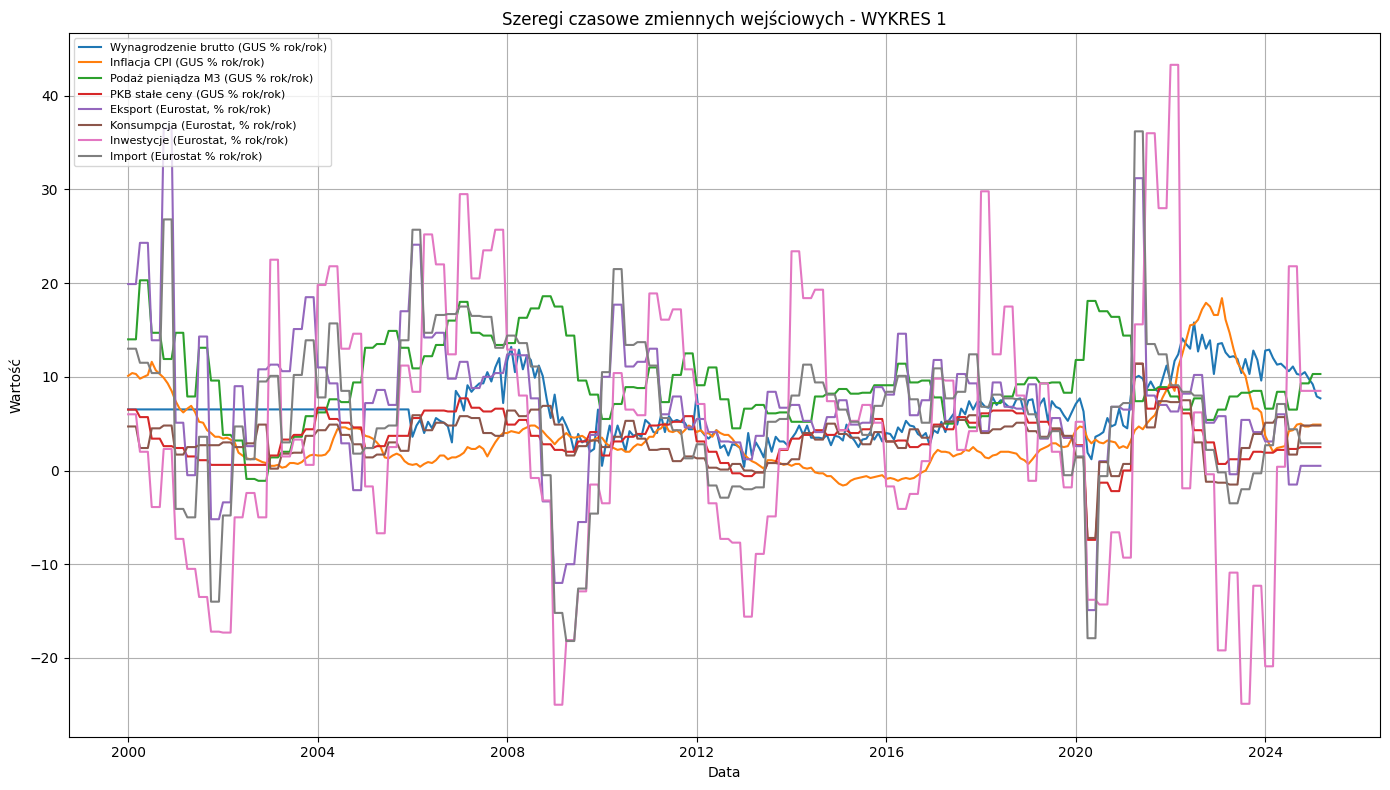

In [ ]:

plt.figure(figsize=(14, 8))
for column in df.filter(regex = r"rok/rok").columns:
    if column.lower() != 'date':
        plt.plot(df.index, df[column], label=column)

plt.title("Szeregi czasowe zmiennych wejściowych - WYKRES 1a")
plt.xlabel("Data")
plt.ylabel("Wartość")

# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# # plt.gcf().autofmt_xdate()

plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


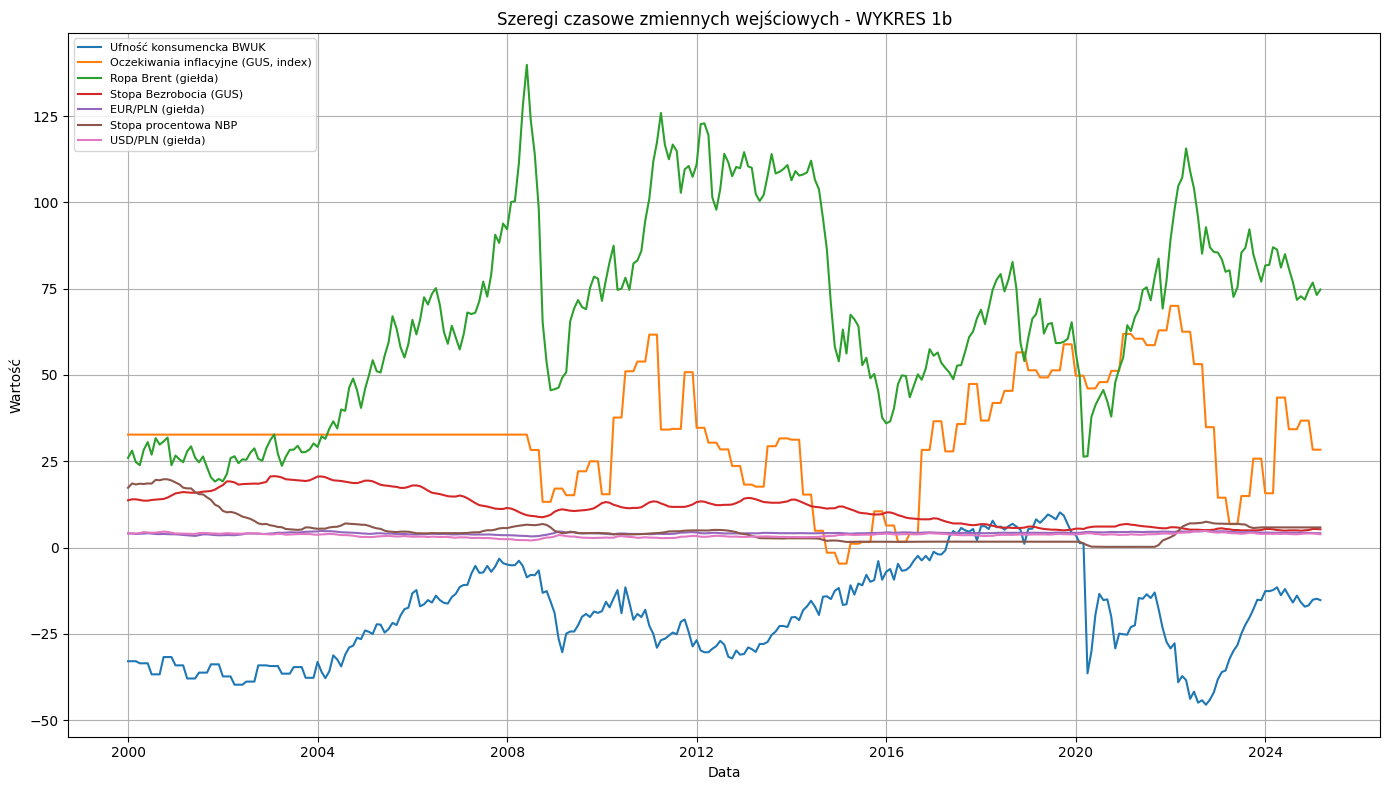

In [35]:

plt.figure(figsize=(14, 8))
for column in set(df.columns).difference(df.filter(regex = r"rok/rok").columns):
    if column.lower() != 'date':
        plt.plot(df.index, df[column], label=column)

plt.title("Szeregi czasowe zmiennych wejściowych - WYKRES 1b")
plt.xlabel("Data")
plt.ylabel("Wartość")

# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# # plt.gcf().autofmt_xdate()

plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Interpretacja wykresu 1

Wykres przedstawia trendy ekonomiczne od 2000 do marca 2025 roku, ukazując zmiany w różnych wskaźnikach, takich jak stopa bezrobocia, inflacja, kursy walutowe, ceny ropy czy PKB. W analizowanym okresie większość wskaźników ekonomicznych wykazywała znaczne wahania, szczególnie w zakresie zaufania konsumentów, ceny ropy Brent oraz oczekiwań inflacyjnych. 

Zgodnie z przewidywaniami, większość zmiennych przedstawiające dynamiki ma niewielką wariancję, w przeciwienstwie pozostałych zmiennych, które nie uległy temu przekształceniu


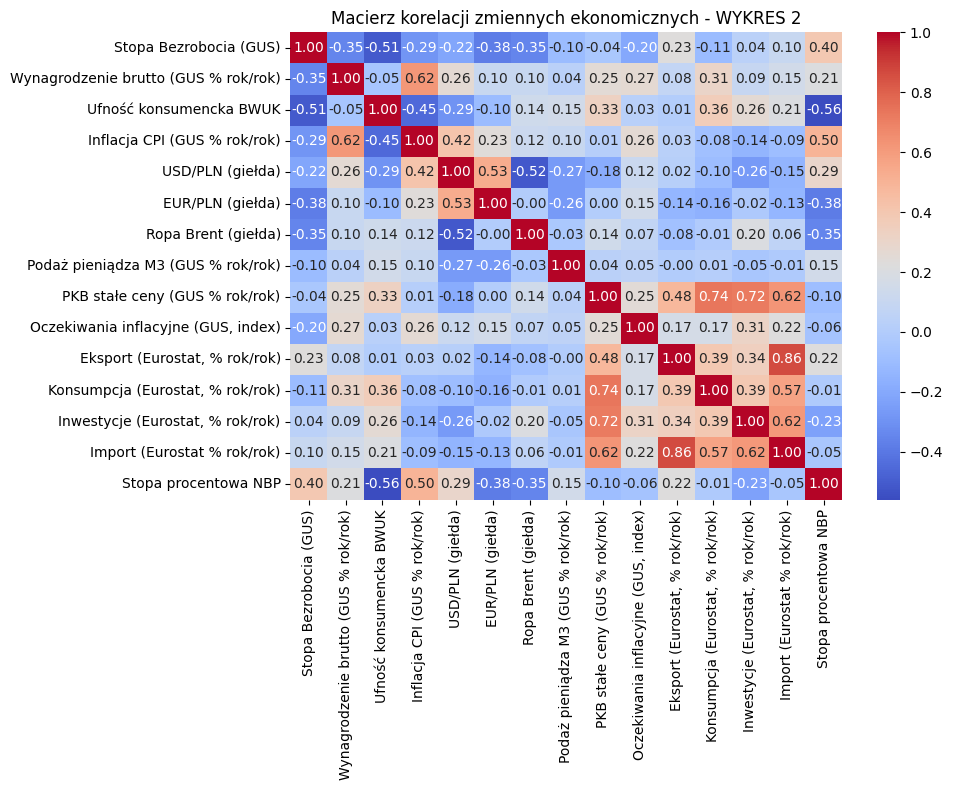

In [36]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji zmiennych ekonomicznych - WYKRES 2")
plt.tight_layout()
plt.show()

#### Interpretacja wykresu 2

Wykres przedstawia macierz korelacji pomiędzy zmiennymi ekonomicznymi, gdzie kolory wskazują siłę i kierunek współzależności między parami zmiennych. Widać silną dodatnią korelację inflacji CPI z wynagrodzeniami brutto (0.62) oraz ujemną korelację z poziomem bezrobocia (-0.29), co jest zgodne z klasycznymi zależnościami makroekonomicznymi. Wysoka dodatnia korelacja stopy procentowej NBP z inflacją (0.50) i ujemna z ufnością konsumencką (-0.56) wskazują na rolę polityki monetarnej w kontrolowaniu inflacji i wpływie stóp procentowych na nastroje gospodarstw domowych.

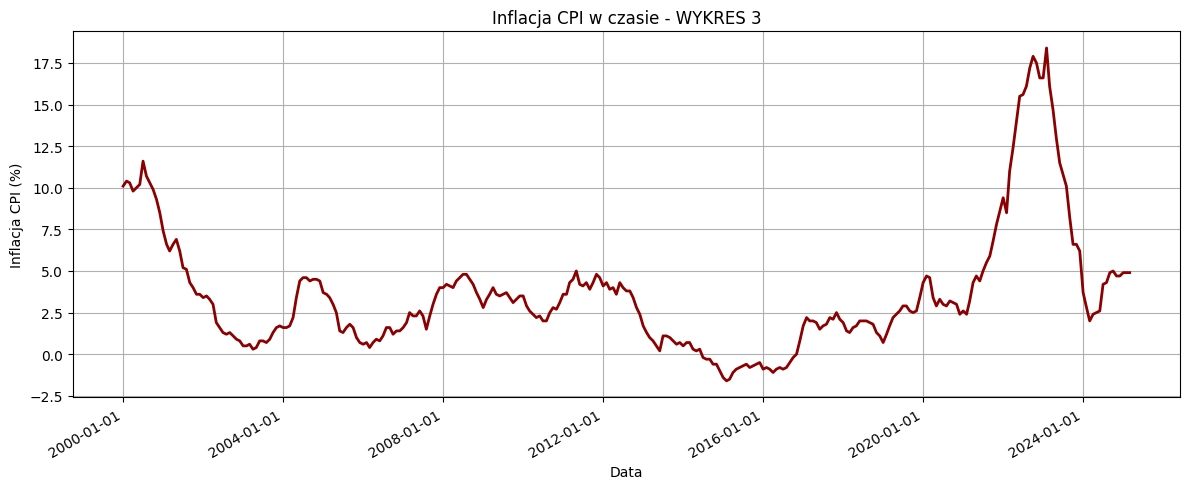

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Inflacja CPI (GUS % rok/rok)'], color='darkred', linewidth=2)

plt.title("Inflacja CPI w czasie - WYKRES 3")
plt.xlabel("Data")
plt.ylabel("Inflacja CPI (%)")

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid(True)
plt.tight_layout()

plt.show()

#### Interpretacja wykresu 3

Wykres przedstawia zmienność inflacji CPI w Polsce w czasie, pokazując zarówno okresy stabilizacji, jak i dynamicznych wzrostów. Szczególnie widoczny jest gwałtowny skok inflacji w ostatnich latach, gdzie wartość CPI przekroczyła 17%. Było to wynikiem, według wielu ekonomistów, szok podażowego wynikającego z wojny w Ukrainie, jak też z powodu luźnej polityki banków centralnych wynikającej z odbudodowy po pandemi COVID-19.

Zgodnie z opinią wielu ekonomistów, inflacja była wówczas dla banków centralnych niespodzianką. W bankach centralnych dominowała wiara w silnie zakotwiczone oczekiwania inflacyjne, które miały sprawić, że ewentualna konieczność walki z inflacją nie byłaby trudną sprawą.

Pytanie, które przyświeca temu raportowi brzmie, czy rzeczywiście tak było? W ramach tego raportu spróbujemy za pomocą sieci LSTM opracować model predycyjny, który być może jest w stanie na podstawie bazy przygotowanych zmiennych skutecznie przewidywać inflacje.

# ➡️ Sieć LSTM

🧩Ten fragment kodu przygotowuje dane makroekonomiczne do trenowania sieci neuronowej typu LSTM w celu prognozowania inflacji CPI. Najpierw dane są wczytywane z pliku Excel i skalowane za pomocą MinMaxScaler, aby ułatwić proces uczenia modelu. Dane wejściowe (cechy) i wyjściowe (inflacja) są przekształcane na sekwencje czasowe, co pozwala LSTM analizować zmiany w czasie. Następnie tworzony jest model LSTM z jedną warstwą rekurencyjną i warstwą wyjściową, który jest trenowany na danych treningowych i walidowany na zbiorze testowym. Po trenowaniu, model generuje predykcje, które są przekształcane z powrotem do oryginalnej skali, a na końcu obliczana jest średniokwadratowa różnica błędu (MSE) między wartościami rzeczywistymi a przewidywanymi.

## Architektura sieci & training

### → Ładowanie danych

In [38]:
df = pd.read_excel("data_modelowanie_inflacji.xlsx")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

target_col = 'Inflacja CPI (GUS % rok/rok)'
all_features = [
    'Stopa Bezrobocia (GUS)',
    'Wynagrodzenie brutto (GUS % rok/rok)', 'Ufność konsumencka BWUK',
    'Ropa Brent (giełda)', 'Podaż pieniądza M3 (GUS % rok/rok)',
    'PKB stałe ceny (GUS % rok/rok)', 'Oczekiwania inflacyjne (GUS, index)',
    'Eksport (Eurostat, % rok/rok)', 'Konsumpcja (Eurostat, % rok/rok)',
    'Inwestycje (Eurostat, % rok/rok)', 'Import (Eurostat % rok/rok)',
    'Stopa procentowa NBP'
]

### → Funkcja do budowania i trenowania LSTM

In [39]:
def build_and_evaluate(features_subset, epochs=20, batch_size=16):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_x.fit_transform(df[features_subset])
    y_scaled = scaler_y.fit_transform(df[[target_col]])

    def create_sequences(X, y, seq_len=12):
        X_seq, y_seq = [], []
        for i in range(seq_len, len(X)):
            X_seq.append(X[i-seq_len:i])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)

    seq_length = 12
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
    dates = df.index[seq_length:]
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X_seq, y_seq, dates, test_size=0.2, shuffle=False)

    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0);

    y_train_inv = scaler_y.inverse_transform(y_train)  # prawdziwe treningowe odskalowane
    y_test_inv = scaler_y.inverse_transform(y_test)     # prawdziwe testowe odskalowane

    y_train_pred = model.predict(X_train)   # predykcje treningowe
    y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)   # predykcje treningowe odskalowane

    y_test_pred = model.predict(X_test)   # predykcje testowe
    y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)  # predykcje testowe odskalowane


    mse = mean_squared_error(y_test_inv, y_test_pred_inv)
    return mse, y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv, dates_train, dates_test

### → Selekcja forward feature  - zaczynając od "Stopa procentowa NBP"


Z powodu ograniczonej mocy obliczeniowej do forward selection oraz w późniejszym fragmencie kodu na etapie backward użyto tylko 20 epok.

🧩Ten fragment kodu realizuje selekcję cech metodą forward selection (dobór progresywny) w celu znalezienia najlepszego zestawu zmiennych do prognozowania inflacji przy użyciu modelu LSTM. Proces zaczyna się od jednej zmiennej bazowej — „Stopa procentowa NBP” — i iteracyjnie testuje dodanie każdej z pozostałych zmiennych, oceniając jakość modelu na podstawie błędu średniokwadratowego (MSE). W każdej iteracji dodawana jest tylko ta zmienna, która najbardziej poprawia wynik (czyli minimalizuje MSE). Jeśli żadna z pozostałych zmiennych nie poprawia wyniku, proces się zatrzymuje. W efekcie końcowym otrzymujemy listę wybranych zmiennych, które najlepiej wspierają prognozowanie inflacji w ramach dostępnych danych.

In [40]:
selected_features = ['Stopa procentowa NBP']
remaining_features = [f for f in all_features if f != 'Stopa procentowa NBP']

# Initial evaluation
mse, y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv, dates_train, dates_test = build_and_evaluate(selected_features)

best_score = mse
best_outputs = {
    'y_train_inv': y_train_inv,
    'y_test_inv': y_test_inv,
    'y_train_pred_inv': y_train_pred_inv,
    'y_test_pred_inv': y_test_pred_inv,
    'dates_train': dates_train,
    'dates_test': dates_test
}

print(f"Starting with {selected_features}, MSE: {best_score:.5f}")

improvement = True

while improvement and remaining_features:
    improvement = False
    best_feature_to_add = None
    best_score_this_round = best_score

    for feature in remaining_features:
        current_features = selected_features + [feature]
        try:
            mse, y_train_inv_tmp, y_test_inv_tmp, y_train_pred_inv_tmp, y_test_pred_inv_tmp, dates_train_tmp, dates_test_tmp = build_and_evaluate(current_features)
            print(f"Testing {current_features}, MSE: {mse:.5f}")
            if mse < best_score_this_round:
                best_score_this_round = mse
                best_feature_to_add = feature
                # Temporarily store the best outputs
                best_outputs_tmp = {
                    'y_train_inv': y_train_inv_tmp,
                    'y_test_inv': y_test_inv_tmp,
                    'y_train_pred_inv': y_train_pred_inv_tmp,
                    'y_test_pred_inv': y_test_pred_inv_tmp,
                    'dates_train': dates_train_tmp,
                    'dates_test': dates_test_tmp
                }
        except Exception as e:
            print(f"Error with {current_features}: {e}")
            continue

    if best_feature_to_add is not None:
        selected_features.append(best_feature_to_add)
        remaining_features.remove(best_feature_to_add)
        best_score = best_score_this_round
        best_outputs = best_outputs_tmp  # Save the best model's outputs
        improvement = True
        print(f"Added {best_feature_to_add}, new best MSE: {best_score:.5f}")
    else:
        print("No improvement, stopping selection.")

print("\nFinal selected features:", selected_features)
print("Final MSE:", best_score)


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Starting with ['Stopa procentowa NBP'], MSE: 49.43797


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing ['Stopa procentowa NBP', 'Stopa Bezrobocia (GUS)'], MSE: 42.23852


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)'], MSE: 39.02617


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing ['Stopa procentowa NBP', 'Ufność konsumencka BWUK'], MSE: 63.41133


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Ropa Brent (giełda)'], MSE: 49.79862


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Podaż pieniądza M3 (GUS % rok/rok)'], MSE: 59.84863


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'PKB stałe ceny (GUS % rok/rok)'], MSE: 51.63906


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Oczekiwania inflacyjne (GUS, index)'], MSE: 41.79602


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Eksport (Eurostat, % rok/rok)'], MSE: 60.17584


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Konsumpcja (Eurostat, % rok/rok)'], MSE: 53.94280


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing ['Stopa procentowa NBP', 'Inwestycje (Eurostat, % rok/rok)'], MSE: 48.82963


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing ['Stopa procentowa NBP', 'Import (Eurostat % rok/rok)'], MSE: 54.72861
Added Wynagrodzenie brutto (GUS % rok/rok), new best MSE: 39.02617


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Stopa Bezrobocia (GUS)'], MSE: 31.05647


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ufność konsumencka BWUK'], MSE: 40.85145


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)'], MSE: 30.46902


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Podaż pieniądza M3 (GUS % rok/rok)'], MSE: 48.97999


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'PKB stałe ceny (GUS % rok/rok)'], MSE: 45.16800


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Oczekiwania inflacyjne (GUS, index)'], MSE: 33.20603


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Eksport (Eurostat, % rok/rok)'], MSE: 37.00689


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Konsumpcja (Eurostat, % rok/rok)'], MSE: 39.21268


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Inwestycje (Eurostat, % rok/rok)'], MSE: 34.89926


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Import (Eurostat % rok/rok)'], MSE: 36.11152
Added Ropa Brent (giełda), new best MSE: 30.46902


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Stopa Bezrobocia (GUS)'], MSE: 31.42760


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Ufność konsumencka BWUK'], MSE: 32.24532


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Podaż pieniądza M3 (GUS % rok/rok)'], MSE: 41.03254


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'PKB stałe ceny (GUS % rok/rok)'], MSE: 35.56740


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Oczekiwania inflacyjne (GUS, index)'], MSE: 37.45777


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Eksport (Eurostat, % rok/rok)'], MSE: 35.60092


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Konsumpcja (Eurostat, % rok/rok)'], MSE: 36.72624


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Inwestycje (Eurostat, % rok/rok)'], MSE: 33.95962


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)', 'Import (Eurostat % rok/rok)'], MSE: 35.27159
No improvement, stopping selection.

Final selected features: ['Stopa procentowa NBP', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ropa Brent (giełda)']
Final MSE: 30.469015624231453


## → Predykcje

### Prognozy - cechy uzyskane z forward selection, epoki = 20


🧩 Ten fragment kodu wizualizuje wyniki prognozowania inflacji uzyskane z modelu LSTM, wytrenowanego na wybranych cechach. Łączy dane treningowe i testowe, porównując rzeczywiste wartości inflacji z prognozami modelu. Na wykresie zaznaczona jest również linia oddzielająca zbiór treningowy od testowego, co pozwala ocenić jakość prognoz w obu okresach.

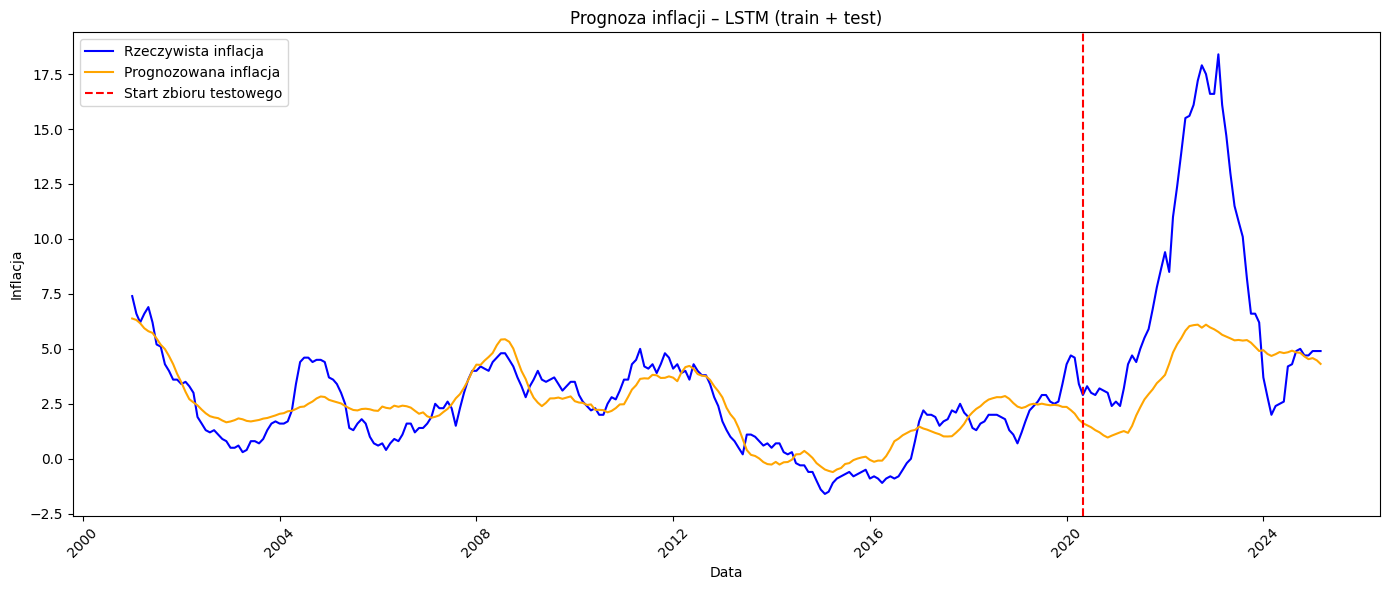

In [41]:
y_train_inv = best_outputs['y_train_inv']
y_test_inv = best_outputs['y_test_inv']
y_train_pred_inv = best_outputs['y_train_pred_inv']
y_test_pred_inv = best_outputs['y_test_pred_inv']
dates_train = best_outputs['dates_train']
dates_test = best_outputs['dates_test']


all_dates = np.concatenate([dates_train, dates_test])
all_actual = np.concatenate([y_train_inv, y_test_inv])  # prawdziwe treningowe i testowe odskalowane
all_pred = np.concatenate([y_train_pred_inv, y_test_pred_inv])  # predykcje treningowe i testowe odskalowane

plt.figure(figsize=(14,6))
plt.plot(all_dates, all_actual, label='Rzeczywista inflacja', color='blue')
plt.plot(all_dates, all_pred, label='Prognozowana inflacja', color='orange')

plt.axvline(x=dates_test[0], color='red', linestyle='--', label='Start zbioru testowego')

plt.title("Prognoza inflacji – LSTM (train + test)")
plt.xlabel("Data")
plt.ylabel("Inflacja")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### Interpretacja wykresu: 

Niebieska linia przedstawia rzeczywiste zmiany inflacji w czasie, czyli faktyczne obserwacje. Natomiast, pomarańczowa linia to wartości przewidywane przez model, które zostały odwrócone ze skali przetworzonej do oryginalnej skali inflacji. Z kolei czerwona pionowa kreska oznacza początek okresu testowego, czyli moment, od którego porównujemy, jak dobrze model radzi sobie z przewidywaniem nowych, niewidzianych danych.

W tym przypadku analizujemy tylko wybrane cechy modelu. 

Z wykresu możemy zauważyć, że model nie aż tak dobrze przewidział prognozy inflacyjne. Wyniki są różne. Natomiast, pomimo daktu, że nie pokrywają się predykcje z rzeczywistymi danymi i tak zauważamy, że wykres zachowuje się podobnie. Przykładowo, rosną predykcje kiedy rzeczywiste dane rosną i spadają kiedy rzeczywiste spadają. Jednakże, nie dzieje się to we wszystkich momentach. Przykładowo pod koniec następuje wzrost rzeczywistych i spadek predykcji.

### → LSTM trenowany na wszystkich features

In [42]:
mse, y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv, dates_train, dates_test = build_and_evaluate(all_features, epochs=100)

c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


###  → Predykcje - wszystkie features

🧩Ten fragment kodu tworzy wykres porównujący rzeczywistą i prognozowaną inflację na podstawie modelu LSTM wytrenowanego na wszystkich dostępnych cechach. Łączy dane treningowe i testowe w jedną sekwencję czasową i przedstawia je na wspólnym wykresie. Czerwona linia przerywana wyznacza początek zbioru testowego, co umożliwia wizualną ocenę jakości prognoz przed i po tym punkcie.

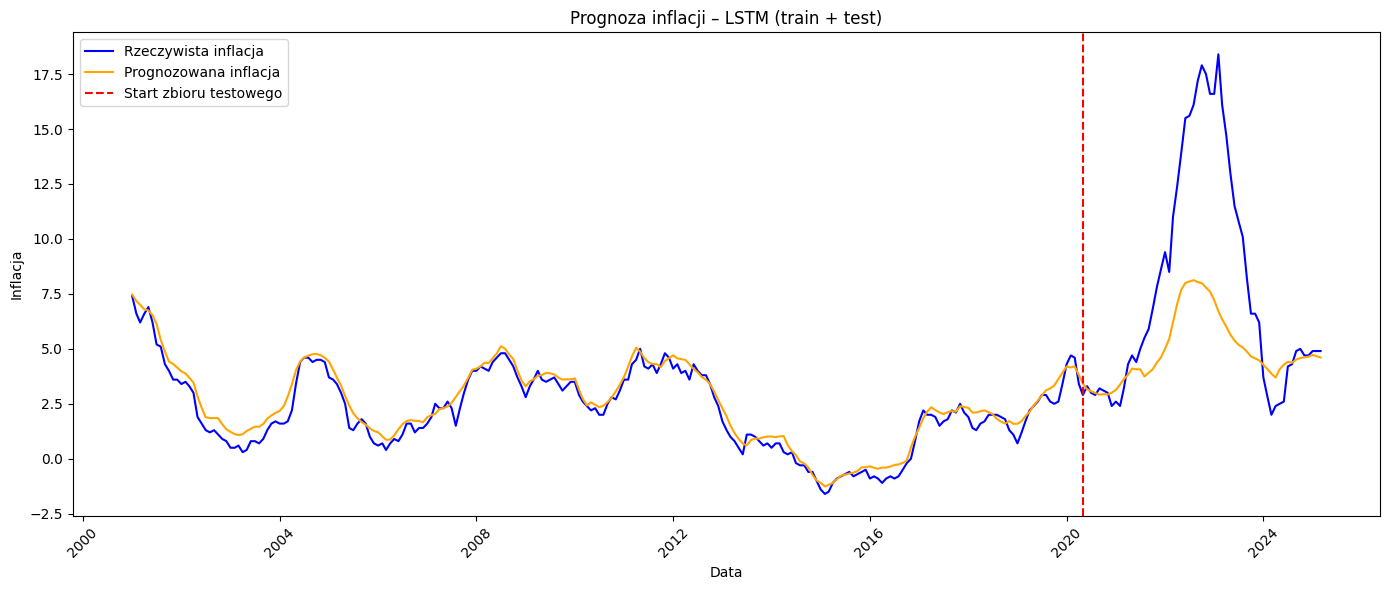

In [43]:

all_dates = np.concatenate([dates_train, dates_test])
all_actual = np.concatenate([y_train_inv, y_test_inv])  # prawdziwe treningowe i testowe odskalowane
all_pred = np.concatenate([y_train_pred_inv, y_test_pred_inv])  # predykcje treningowe i testowe odskalowane

plt.figure(figsize=(14,6))
plt.plot(all_dates, all_actual, label='Rzeczywista inflacja', color='blue')
plt.plot(all_dates, all_pred, label='Prognozowana inflacja', color='orange')

plt.axvline(x=dates_test[0], color='red', linestyle='--', label='Start zbioru testowego')

plt.title("Prognoza inflacji – LSTM (train + test)")
plt.xlabel("Data")
plt.ylabel("Inflacja")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Interpretacja wykresu: 
 
W tym wypadku wzięliśmy wszystkie cechy do analizy. 

Z wykresu możemy zauważyć, że model nie aż tak dobrze przewidział prognozy inflacyjne. Wyniki są różne. Natomiast, pomimo daktu, że nie pokrywają się predykcje z rzeczywistymi danymi i tak zauważamy, że wykres zachowuje się podobnie. Przykładowo, rosną predykcje kiedy rzeczywiste dane rosną i spadają kiedy rzeczywiste spadają. 

Co więcej, wykres na wszystkich cechach radzi sobie lepiej niż na wybranych. 


## ➡️ Backward selection


🧩 Ten fragment kodu przeprowadza selekcję cech metodą backward selection – zaczynając od wszystkich dostępnych zmiennych, model iteracyjnie usuwa te, których eliminacja nie pogarsza dokładności prognozy (mierzonej błędem MSE). W każdej iteracji usuwana jest zmienna, której brak przynosi największą poprawę lub najmniejszy spadek jakości modelu. Proces ten trwa do momentu, aż dalsze usuwanie cech przestaje przynosić korzyści. Po zakończeniu selekcji, kod zapisuje najlepszy wynik modelu oraz zestaw użytych cech. Na końcu tworzony jest wykres porównujący rzeczywiste i prognozowane wartości inflacji w czasie, z zaznaczeniem momentu przejścia do zbioru testowego.

In [44]:
selected_features = all_features.copy()

# Initial evaluation
mse, y_train_inv, y_test_inv, y_train_pred_inv, y_test_pred_inv, dates_train, dates_test = build_and_evaluate(selected_features)

best_score = mse
best_outputs = {
    'y_train_inv': y_train_inv,
    'y_test_inv': y_test_inv,
    'y_train_pred_inv': y_train_pred_inv,
    'y_test_pred_inv': y_test_pred_inv,
    'dates_train': dates_train,
    'dates_test': dates_test
}

print(f"Starting with all features, MSE: {best_score:.5f}")

improvement = True

while improvement and len(selected_features) > 1:
    improvement = False
    worst_feature_to_remove = None
    best_score_this_round = best_score

    for feature in selected_features:
        current_features = [f for f in selected_features if f != feature]
        try:
            mse, y_train_inv_tmp, y_test_inv_tmp, y_train_pred_inv_tmp, y_test_pred_inv_tmp, dates_train_tmp, dates_test_tmp = build_and_evaluate(current_features)
            print(f"Testing without {feature}, MSE: {mse:.5f}")
            if mse <= best_score_this_round:
                best_score_this_round = mse
                worst_feature_to_remove = feature
                best_outputs_tmp = {
                    'y_train_inv': y_train_inv_tmp,
                    'y_test_inv': y_test_inv_tmp,
                    'y_train_pred_inv': y_train_pred_inv_tmp,
                    'y_test_pred_inv': y_test_pred_inv_tmp,
                    'dates_train': dates_train_tmp,
                    'dates_test': dates_test_tmp
                }
        except Exception as e:
            print(f"Error when testing without {feature}: {e}")
            continue

    if worst_feature_to_remove is not None:
        selected_features.remove(worst_feature_to_remove)
        best_score = best_score_this_round
        best_outputs = best_outputs_tmp
        improvement = True
        print(f"Removed {worst_feature_to_remove}, new best MSE: {best_score:.5f}")
    else:
        print("No improvement, stopping backward selection.")

print("\nFinal selected features:", selected_features)
print("Final MSE:", best_score)


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Starting with all features, MSE: 21.53353


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Stopa Bezrobocia (GUS), MSE: 35.05395


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Wynagrodzenie brutto (GUS % rok/rok), MSE: 36.26164


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Ufność konsumencka BWUK, MSE: 47.42776


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing without Ropa Brent (giełda), MSE: 29.98301


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Podaż pieniądza M3 (GUS % rok/rok), MSE: 41.42682


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without PKB stałe ceny (GUS % rok/rok), MSE: 36.98497


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Testing without Oczekiwania inflacyjne (GUS, index), MSE: 31.14373


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Eksport (Eurostat, % rok/rok), MSE: 18.29215


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Konsumpcja (Eurostat, % rok/rok), MSE: 22.75570


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Inwestycje (Eurostat, % rok/rok), MSE: 23.91428


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Import (Eurostat % rok/rok), MSE: 21.49758


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Stopa procentowa NBP, MSE: 53.85690
Removed Eksport (Eurostat, % rok/rok), new best MSE: 18.29215


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Stopa Bezrobocia (GUS), MSE: 33.03586


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Wynagrodzenie brutto (GUS % rok/rok), MSE: 31.82865


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Ufność konsumencka BWUK, MSE: 30.55180


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Ropa Brent (giełda), MSE: 25.08368


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Podaż pieniądza M3 (GUS % rok/rok), MSE: 23.56045


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without PKB stałe ceny (GUS % rok/rok), MSE: 16.09473


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Oczekiwania inflacyjne (GUS, index), MSE: 31.61252


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Konsumpcja (Eurostat, % rok/rok), MSE: 39.19652


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Inwestycje (Eurostat, % rok/rok), MSE: 25.44082


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Import (Eurostat % rok/rok), MSE: 23.10327


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Stopa procentowa NBP, MSE: 28.03655
Removed PKB stałe ceny (GUS % rok/rok), new best MSE: 16.09473


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Stopa Bezrobocia (GUS), MSE: 30.53924


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Wynagrodzenie brutto (GUS % rok/rok), MSE: 22.21377


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Ufność konsumencka BWUK, MSE: 37.95895


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Ropa Brent (giełda), MSE: 14.56072


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Podaż pieniądza M3 (GUS % rok/rok), MSE: 23.06589


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing without Oczekiwania inflacyjne (GUS, index), MSE: 28.01559


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Konsumpcja (Eurostat, % rok/rok), MSE: 19.35466


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing without Inwestycje (Eurostat, % rok/rok), MSE: 16.56091


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Import (Eurostat % rok/rok), MSE: 15.96935


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Stopa procentowa NBP, MSE: 24.08035
Removed Ropa Brent (giełda), new best MSE: 14.56072


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing without Stopa Bezrobocia (GUS), MSE: 32.94098


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Wynagrodzenie brutto (GUS % rok/rok), MSE: 24.83750


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Ufność konsumencka BWUK, MSE: 40.69566


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Podaż pieniądza M3 (GUS % rok/rok), MSE: 21.01275


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Oczekiwania inflacyjne (GUS, index), MSE: 33.53629


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Konsumpcja (Eurostat, % rok/rok), MSE: 5.97367


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Inwestycje (Eurostat, % rok/rok), MSE: 30.82512


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Import (Eurostat % rok/rok), MSE: 22.80717


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Testing without Stopa procentowa NBP, MSE: 26.33955
Removed Konsumpcja (Eurostat, % rok/rok), new best MSE: 5.97367


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Testing without Stopa Bezrobocia (GUS), MSE: 49.05873


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Wynagrodzenie brutto (GUS % rok/rok), MSE: 31.90325


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Ufność konsumencka BWUK, MSE: 49.94134


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing without Podaż pieniądza M3 (GUS % rok/rok), MSE: 19.84407


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Oczekiwania inflacyjne (GUS, index), MSE: 41.27798


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Inwestycje (Eurostat, % rok/rok), MSE: 22.20366


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing without Import (Eurostat % rok/rok), MSE: 14.09821


c:\Users\rados\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing without Stopa procentowa NBP, MSE: 12.35040
No improvement, stopping backward selection.

Final selected features: ['Stopa Bezrobocia (GUS)', 'Wynagrodzenie brutto (GUS % rok/rok)', 'Ufność konsumencka BWUK', 'Podaż pieniądza M3 (GUS % rok/rok)', 'Oczekiwania inflacyjne (GUS, index)', 'Inwestycje (Eurostat, % rok/rok)', 'Import (Eurostat % rok/rok)', 'Stopa procentowa NBP']
Final MSE: 5.973665295932377


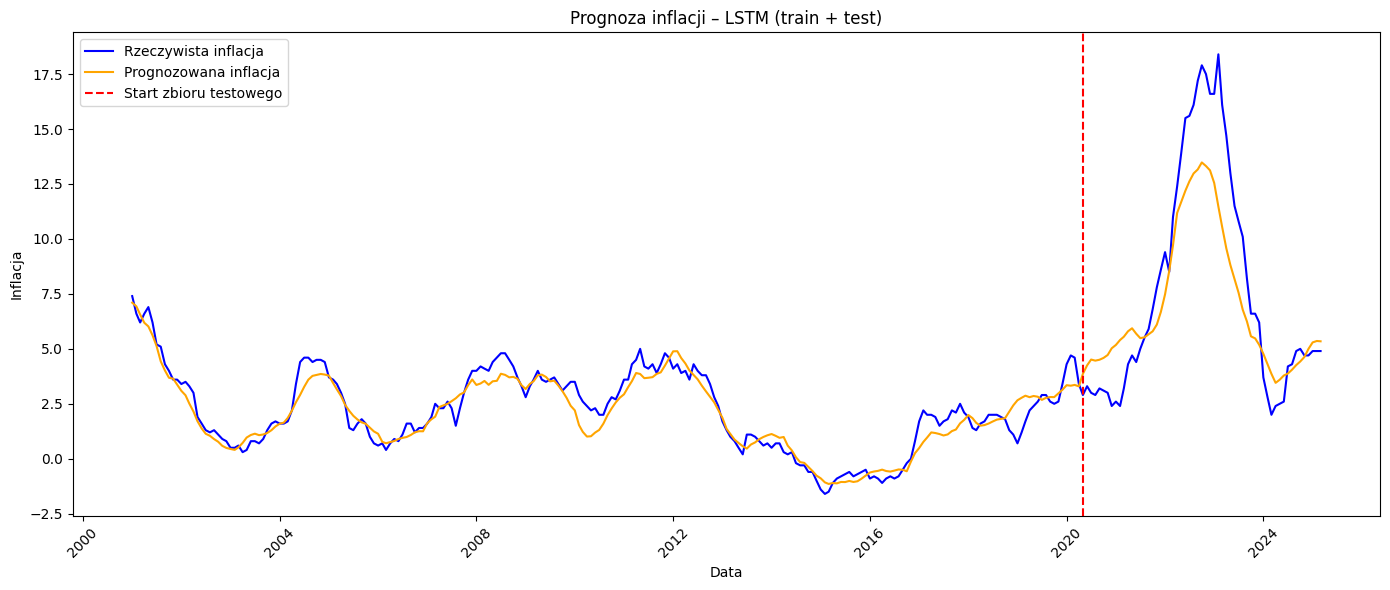

In [45]:
y_train_inv = best_outputs['y_train_inv']
y_test_inv = best_outputs['y_test_inv']
y_train_pred_inv = best_outputs['y_train_pred_inv']
y_test_pred_inv = best_outputs['y_test_pred_inv']
dates_train = best_outputs['dates_train']
dates_test = best_outputs['dates_test']


all_dates = np.concatenate([dates_train, dates_test])
all_actual = np.concatenate([y_train_inv, y_test_inv])  # prawdziwe treningowe i testowe odskalowane
all_pred = np.concatenate([y_train_pred_inv, y_test_pred_inv])  # predykcje treningowe i testowe odskalowane

plt.figure(figsize=(14,6))
plt.plot(all_dates, all_actual, label='Rzeczywista inflacja', color='blue')
plt.plot(all_dates, all_pred, label='Prognozowana inflacja', color='orange')

plt.axvline(x=dates_test[0], color='red', linestyle='--', label='Start zbioru testowego')

plt.title("Prognoza inflacji – LSTM (train + test)")
plt.xlabel("Data")
plt.ylabel("Inflacja")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Interpretacja wykresu: 

W tym wypadku wytrenowaliśmy model selekcją cech metodą backward selection.

Metoda działa w następujący sposób:
Początkowo model jest trenowany na wszystkich dostępnych cechach, a jego błąd średniokwadratowy (MSE) jest mierzony jako punkt odniesienia. Następnie, w kolejnych iteracjach, każda cecha jest kolejno usuwana, a model jest trenowany na pozostałych cechach, by sprawdzić, czy jej usunięcie poprawia (lub co najmniej nie pogarsza) wyniku MSE.

Wyniki wykresu okazały się zdecydowanie lepsze niż porównując poprzednie wykresy. Prognozy dobrze pokrywają się z rzeczywistymi danymi, oznacza to, że wybrane cechy i model dobrze uchwyciły wzorce inflacji.Zdecydowanie lepiej niż w poprzednich przypadkach. Jednakże na samym końcu mamy sytuacje kiedy dane aktualne nie pokrywają się z predykcjami.

## Podsumowanie / Wnioski z badania: 

* **Model LSTM** na cechach wybranych metodą forward selection dobrze odwzorowuje ogólny trend inflacji, szczególnie na zbiorze treningowym.
* **Forward selection** pomogła wybrać cechy, które istotnie wpływają na poprawę jakości prognozy.
* W początkowej części okresu testowego **prognozy są zbliżone do rzeczywistych danych**, co świadczy o dobrej zdolności generalizacji modelu.
* Na końcowym fragmencie okresu testowego **model ma trudności** z dokładnym przewidzeniem gwałtownych zmian inflacji.
* Prognozy **zachowują poprawną kierunkowość zmian** (rosną, gdy inflacja rośnie i maleją, gdy inflacja spada), co jest pozytywnym sygnałem.
* Wciąż **istnieje pewna rozbieżność między rzeczywistymi a przewidywanymi wartościami**, co sugeruje możliwość dalszej optymalizacji modelu lub doboru cech.
* Chociaż forward selection poprawiła jakość prognoz w porównaniu do modelu trenowanego na wszystkich cechach, to jednak **metoda backward selection okazała się najlepsza**, osiągając najbardziej precyzyjne i stabilne prognozy inflacji.

Co najbardziej istotne, model poprawnie przewiduje tendencje inflacyjnie przewidując nagły wzrost w roku 2022 nawet szybciej, niż on nastąpił w rzeczywistości. Model jednak nie zbyt dokładnie poziomu inflacje na zbiorze testowym, ale zachował poprawną trajektorie tych zmian. Nie jest to dziwne, ponieważ szkok podażowy wynikający z wojny w Ukrainy mógł i zerwania światowych łańcuchów dostaw mógł być ciężki do przewidzenia przez sieć nauronową, ktora nie miała odpowiednich danych w zbiorze treningowych na temat tego typu nadzwyzczajnych zjawisk. Tym bardziej uzyskane predykcje można uznać za zadowalające

## Bibliografia

1.. Eurostat. (2024). Eurostat Data Portal [Dane statystyczne]. Pobrane z https://ec.europa.eu/eurostat/data/database

2.. Główny Urząd Statystyczny (GUS). (2024). Baza danych statystycznych GUS. Pobrane z https://stat.gov.pl/

3.. Stooq.pl. (2024). Dane historyczne kursów walutowych USD/PLN i EUR/PLN. Pobrane z https://stooq.pl/

4.. Yahoo Finance. (2024). Historical Brent Oil Futures Data. Pobrane z https://finance.yahoo.com/

5.. Chollet, F. (2018). Deep Learning with Python. Manning Publications. (biblioteka Keras do budowy modelu LSTM)

6.. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830. (biblioteka sklearn)